In [28]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
pd.options.plotting.backend = "plotly"
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, breakvar_heteroskedasticity_test
from scipy.stats import wilcoxon, shapiro, jarque_bera
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings('ignore')



from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [24]:
#leitura dos dados
total = (pd.read_csv('dataset/dataset_total.csv').set_index('Data').drop(['Consumidores', 'Dias'],axis=1)/1000)[:-36]

teste = total[-36:]
total = total[:-36]


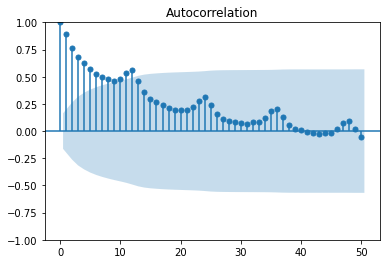

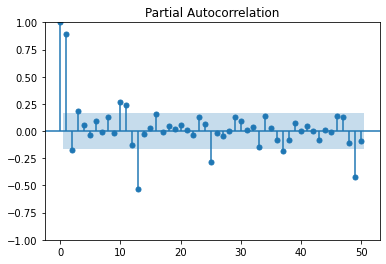

In [50]:
plot_acf(total, lags=50);
plot_pacf(total, lags=50);

In [51]:
#ADF
print(adfuller(total)[1])

0.14926037793338398


In [52]:
diff12 = (total - total.shift(12)).dropna()
diff12.plot(title='Diferença Sazonal')

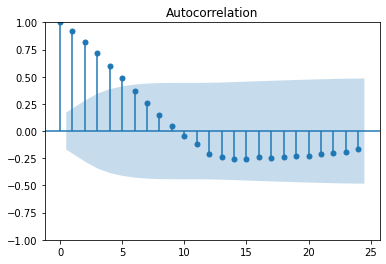

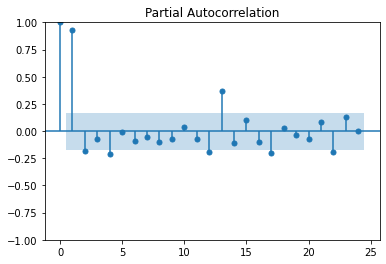

In [82]:
plot_acf(diff12, lags=24);
plot_pacf(diff12, lags=24);

In [59]:
#ADF
print(adfuller(diff12)[1])

0.42031815667452194


In [61]:
diff12_1 = (diff12 - diff12.shift()).dropna()
diff12_1.plot()

In [62]:
#ADF
print(adfuller(diff12_1)[1])

2.0337876338532918e-05


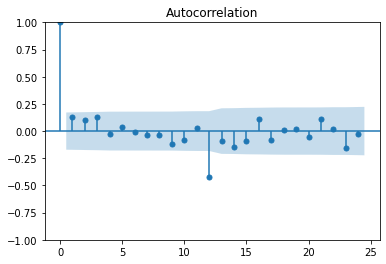

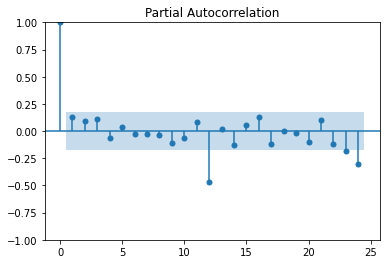

In [86]:
#testar (0,1,0])x([0,1],1,[0,1])

plot_acf(diff12_1, lags=24);
plot_pacf(diff12_1, lags=24);

In [73]:
model = auto_arima(total, start_p=0, start_q=0, max_p=3, max_q=3, max_d=2,
                                    start_P=0, start_Q=0, m=12, max_P=3, max_Q=3, max_D=2,
                    max_order=30,
                    seasonal=True,
                    information_criterion='bic',
                    stepwise=False,
                    use_exact_diffuse=True,
                    n_fits=50,)

In [74]:
print(model.order, model.seasonal_order)

(0, 1, 0) (1, 0, 1, 12)


In [75]:
model = auto_arima(diff12, start_p=0, start_q=0, max_p=3, max_q=3, max_d=2,
                                    start_P=0, start_Q=0, m=12, max_P=3, max_Q=3, max_D=2,
                    max_order=30,
                    seasonal=True,
                    information_criterion='bic',
                    stepwise=False,
                    use_exact_diffuse=True,
                    n_fits=50,)

In [76]:
print(model.order, model.seasonal_order)

(1, 0, 0) (0, 0, 1, 12)


In [77]:
model = auto_arima(diff12_1, start_p=0, start_q=0, max_p=3, max_q=3, max_d=2,
                                    start_P=0, start_Q=0, m=12, max_P=3, max_Q=3, max_D=2,
                    max_order=30,
                    seasonal=True,
                    information_criterion='bic',
                    stepwise=False,
                    use_exact_diffuse=True,
                    n_fits=50,)

In [78]:
print(model.order, model.seasonal_order)

(0, 0, 0) (0, 0, 1, 12)


In [90]:
#CrossValidation
model1 = pm.ARIMA(order=(0, 1, 0),
                  seasonal_order=(2, 1, 0, 12),
                  suppress_warnings=True)
model2 = pm.ARIMA(order=(0, 1, 0),
                  seasonal_order=(0, 1, 1, 12),
                  suppress_warnings=True)
model3 = pm.ARIMA(order=(0, 1, 0),
                  seasonal_order=(1, 0, 1, 12),
                  suppress_warnings=True) 
model4 = pm.ARIMA(order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 12),
                  suppress_warnings=True)
model5 = pm.ARIMA(order=(0, 1, 0),
                  seasonal_order=(0, 1, 1, 12),
                  suppress_warnings=True)



cv = model_selection.RollingForecastCV(initial=144, step=1, h=1)

model1_cv_scores = model_selection.cross_val_score(
    model1, total.append(teste), scoring='mean_squared_error', cv=cv, verbose=0)
#print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))

model2_cv_scores = model_selection.cross_val_score(
    model2, total.append(teste), scoring='mean_squared_error', cv=cv, verbose=0)
#print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))

model3_cv_scores = model_selection.cross_val_score(
    model3, total.append(teste), scoring='mean_squared_error', cv=cv, verbose=0)
#print("Model 3 CV scores: {}".format(model3_cv_scores.tolist()))

model4_cv_scores = model_selection.cross_val_score(
    model4, total.append(teste), scoring='mean_squared_error', cv=cv, verbose=0)
#print("Model 4 CV scores: {}".format(model4_cv_scores.tolist()))
model5_cv_scores = model_selection.cross_val_score(
    model5, total.append(teste), scoring='mean_squared_error', cv=cv, verbose=0)

# Pick based on which has a lower mean error rate
m1_average_error = np.average(model1_cv_scores)
m2_average_error = np.average(model2_cv_scores)
m3_average_error = np.average(model3_cv_scores)
m4_average_error = np.average(model4_cv_scores)
m5_average_error = np.average(model5_cv_scores)


errors = [m1_average_error, m2_average_error, m3_average_error, m4_average_error, m5_average_error]
models = [model1, model2, model3, model4, model5]

# print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average MSE: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))


Lowest average MSE: 94618.33676555008 (model4)
Best model:  ARIMA(1,0,0)(0,1,1)[12] intercept


In [138]:
np.sqrt(errors)

array([353.26911659, 339.13434758, 333.87914973, 307.60093752,
       339.13434758])

In [108]:
pd.options.plotting.backend = 'matplotlib'

In [135]:
mod = sm.tsa.statespace.SARIMAX(total.append(teste),
                            order=(1,0,0),
                            seasonal_order=(1,1,0,12),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()

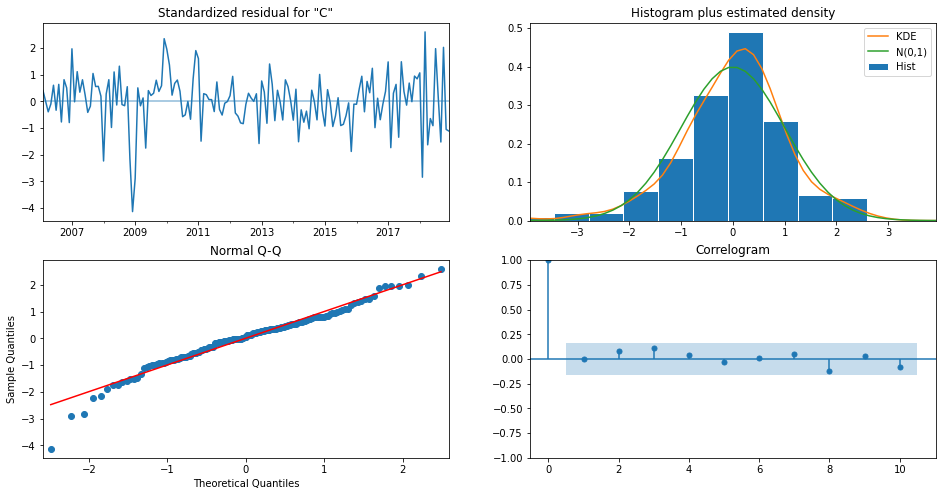

In [136]:
mod.plot_diagnostics(figsize=(16,8));

In [137]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Consumo   No. Observations:                  180
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -1096.135
Date:                            Sun, 10 Apr 2022   AIC                           2198.269
Time:                                    23:58:53   BIC                           2207.400
Sample:                                01-01-2004   HQIC                          2201.978
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9284      0.035     26.563      0.000       0.860       0.997
ar.S.L12      -0.3828      0.056     -6.847      0.000      -0.492      -0.273
sigma2      8.129e+04   6717.539     12.101      0.000    6.81e+04    9.45e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                30.76
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.60
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""